# Machine Learning Data -> 05 - Feature Engineering

---

Now, we are going to apply some ML algorithms on lightcurves contained: 

- 0: Confirmed Exoplanets
- 1: Eclipsing Binaries
- 2: Non Eclipsed

With that in mind, the data from (1) and (2) will be downloaded from the [CoRoT Public Archive](http://idoc-corot.ias.u-psud.fr/sitools/client-user/COROT_N2_PUBLIC_DATA/project-index.html) and transformed into CSV files, just like we did for (0): Confirmed Exoplanets on `01 - Manipulating fits files`

# Classification algorithms

---



# Feature: Periodograms

---




In [3]:
import pandas as pd

PERIODOGRAMS_DIR = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/features/periodogram_feature.csv'

data_per = pd.read_csv(PERIODOGRAMS_DIR)
data_per.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500,7501,7502,7503,7504,7505,7506,7507,7508,7509,7510,7511,7512,7513,7514,7515,7516,7517,7518,7519,7520,7521,7522,7523,7524,7525,label
51,1.223030e-20,30960.146108,35315.310143,4176.471785,1360.395162,5035.111344,1889.094503,2023.471673,7340.965581,4289.552635,3995.439483,1584.676345,213.050994,836.925224,1194.204549,95.015227,1574.542204,1885.822540,655.916650,1173.790046,302.816855,218.939627,1127.677653,5953.057958,5472.641841,144868.045291,3823.134079,134.826853,3417.939630,774.991428,9349.258021,8240.146926,4066.322737,3027.521521,65.910294,1112.526162,99.662234,401.312307,380.091689,236.437898,...,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000141,1
97,2.690706e-23,870.329530,4374.014382,241.297285,1091.184430,902.154421,317.156397,474.677574,1212.002323,107.308339,143.650961,437.107047,365.776411,135.046159,102.039933,121.264515,73.096038,12.809064,122.507477,141.070735,30.948384,84.338729,47.881403,27.193505,2.649810,9.414482,26.971884,3.364537,158.812306,7.129188,92.659425,11.933758,19.705526,35.733975,14.822395,7.020242,23.448927,23.214880,63.517796,4.175995,...,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000090,1
60,2.352545e-22,3681.101281,2801.414929,5252.431106,2724.432954,738.058862,4506.499391,1332.964245,3143.738458,1566.658498,1904.469479,3329.182693,2435.436511,3897.541448,1599.203254,1088.456166,641.202106,1114.103396,1309.514734,1933.088010,2056.458680,1337.242988,2055.852609,2012.779506,2487.154564,2264.664270,2569.654927,1413.508469,1157.261035,1151.517904,359.194474,705.381107,715.292009,909.152925,1222.690282,1418.997002,1180.397146,1571.432812,1647.403802,2099.387677,...,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.005712,0.002856,1
109,2.998708e-22,30832.759594,402439.722498,308337.306932,112154.593264,45435.542562,16352.744141,92356.357025,4383.247519,9409.807771,32298.448078,4159.157664,14262.089843,1576.586485,2916.450276,10060.745354,15979.546926,5344.938421,12978.194206,8327.722452,2373.306792,4247.772738,2870.651644,16725.115722,3934.471674,9394.707037,1650.010175,15932.838067,4522.772410,3203.787901,118.111240,8985.402103,4774.658964,4333.624885,3171.465168,785.050321,2705.029239,1388.885410,1543.668936,1590.623534,...,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013148,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.013147,0.006574,1
63,3.877741e-22,6451.970057,4445.204568,106.667393,10938.841281,5557.751312,3413.284953,4150.415498,3518.243621,1874.083378,5258.922846,82828.927238,27949.536808,4409.198970,2323.407261,815.283540,731.131800,3174.268789,976.433937,516.795138,1376.289285,2141.399578,6779.991608,89165.547904,830.071210,82.986044,77.741505,343.838167,3116.791583,2088.555818,20.871069,38.449062,118.7021

How much of each label we have at this dataset ?

In [4]:
data_per['label'].value_counts()

1    98
0    33
Name: label, dtype: int64

It is noticeable that the data is unbalanced. To handle this, just deleting a few *label 1: eclipsing binaries* rows should suffice. 

In [5]:
num_rows_to_remove = 40

data_per.drop(data_per.index[len(data_per)-num_rows_to_remove:], inplace=True)
print(data_per['label'].value_counts())

1    58
0    33
Name: label, dtype: int64


Great! Now let's jump over the general machine learning pipeline.



## Preprocessing

For preprocessing, we will use the following pipeline:

- Divide data into matrix of features (independent variable) and labels (dependent variable vector)
- Apply feature scalling (normalization or standardization)
- Dimensionality Reduction - PCA
- Split data into train and test set

**1 - Divide data into *X: matrix of features* and *y: labels***

In [6]:
X = data_per.iloc[:, :-1].values    # Matrix of features (Independent variable), X: numpy.ndarray
y = data_per.iloc[:, -1].values     # Vector of labels (Dependent variable), y: numpy.ndarray

**2 - Normalization**

In [7]:
from sklearn import preprocessing

X_normalized = preprocessing.normalize(X)

**3 - Principal Component Analysis**

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# What is the minimun value of `n_components` to keep 95% of variance on data ?

pca = PCA()
pca.fit(X_normalized)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1

print("The minimun value is:", d)

The minimun value is: 60


In [9]:
pca = PCA(n_components=d)
pca.fit(X_normalized)
X_reduced = pca.transform(X_normalized)

Best altenative... set the `n_components` to fluctuate between 0.0 and 1.0, indicating the rate of variance you want to preserve

In [10]:
pca = PCA(n_components=0.99)
X_reduced = pca.fit_transform(X_normalized)
print(X_normalized.shape)
print(X_reduced.shape)

# pca = PCA(n_components=68, svd_solver='arpack')
# X_reduced = pca.fit_transform(X_normalized)
# print(X_normalized.shape)
# print(X_reduced.shape)

(91, 7526)
(91, 60)


**4 - Splitting the dataset into the Training set and Test set**

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.33, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 7526) (60,) (31, 7526) (31,)


## Training multiple models

In [12]:
from sklearn.metrics import accuracy_score

def evaluate_model(model_name, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  return f'{model_name}:\nAccuracy: {accuracy:.4f}\n'

Models to train: 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# model_lr = LogisticRegression(random_state = 0)
# model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# model_svm = SVC(kernel = 'linear', random_state = 0)
# model_kernel_svm = SVC(kernel = 'rbf', random_state = 0)
# model_nb = GaussianNB()
# model_dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
# model_rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# model_xgb = XGBClassifier(learning_rate = 0.3, max_depth = 6, n_estimators = 15)

model_lr  = LogisticRegression(random_state = 0)
model_knn = KNeighborsClassifier()
model_svm = SVC(random_state = 0)
model_nb  = GaussianNB()
model_dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
model_rfc = RandomForestClassifier(criterion = 'entropy', random_state = 0)
model_xgb = XGBClassifier(random_state = 0)

models = {
    'LogisticRegression': model_lr,
    'KNN': model_knn,
    'SVM': model_svm,
    'NaiveBayes': model_nb,
    'DecisionTree': model_dtc,
    'RandomForest': model_rfc,
    'XGBoost': model_xgb
    }

In [14]:
import time

t0 = time.time()

for model_name, model in models.items():
  # Train
  model.fit(X_train, y_train)
  # Test
  y_pred = model.predict(X_test)
  print(evaluate_model(model_name, y_test, y_pred))

tf = time.time()

print('\nIt takes', round(tf-t0, 4), 'seconds to train the models')

LogisticRegression:
Accuracy: 0.8065

KNN:
Accuracy: 0.8065

SVM:
Accuracy: 0.8065

NaiveBayes:
Accuracy: 0.7419

DecisionTree:
Accuracy: 0.6774

RandomForest:
Accuracy: 0.8710

XGBoost:
Accuracy: 0.7419


It takes 2.3854 seconds to train the models


## Selecting the best models and hyperparameter tuning them 

In [18]:
from pprint import pprint

### Random Forest Classifier

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [20]:
print('Parameters currently in use:\n')
pprint(model_rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid_RF = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
  }


pprint(param_grid_RF)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
from sklearn.model_selection import RandomizedSearchCV

model_RF = RandomForestClassifier()
model_RF_random = RandomizedSearchCV(estimator=model_RF, param_distributions=param_grid_RF, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
model_RF_random.fit(X_train, y_train)

pprint(model_RF_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}


### Support Vector Machine Classifier

### Knn

### Logistic Regression

### XGBoost - why not ?

## Confusion matrix

In [ ]:
# Confusion Matrix function
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

labels_formated = ['confirmed exoplanets', 'eclipsing binaries']

def confusion_matrix(model, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  model_name = str(model)[:str(model).find('(')]

  fig = plot_confusion_matrix(model, X_test, y_test,
                              display_labels=labels_formated,
                              cmap=plt.cm.Blues,
                              normalize='true'
                              )
  
  fig.ax_.set_title(f'{model_name} - Confusion matrix\n')
  plt.show()
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy*100, 2)
  print(f'Accuracy = {accuracy} %')

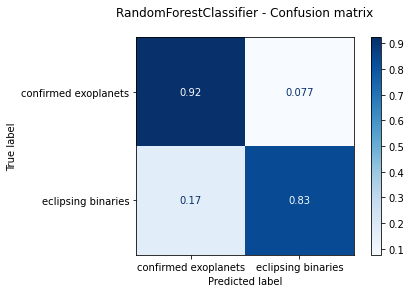

Accuracy = 87.1 %


In [ ]:
confusion_matrix(model_rfc, X_test, y_test)

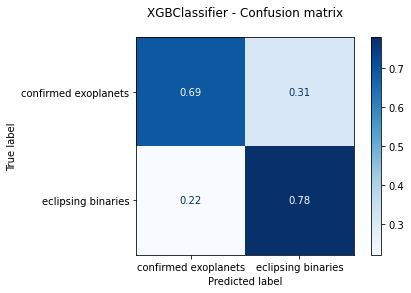

Accuracy = 74.19 %


In [ ]:
confusion_matrix(model_xgb, X_test, y_test)

## Hyperparameters tuning

From the previously prediction results, we selected *Random Forest*, *XGBoost*, *Suport Vector Machine* and *Naive Bayes* Classifiers

## Train model - XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

accuracies=np.zeros(100)

# Define the model parameters
param_dist = {
    'objective': 'binary:logistic',
    'learning_rate': 0.3,
    'max_depth': 6,
    'n_estimators': 11
}

# Create the range parameters to search
n_estimators = [ k+1 for k in range(100)]

# search for the best k
for n_estimator in n_estimators:
    param_dist['n_estimators'] = n_estimator
    model = XGBClassifier(**param_dist)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracies[n_estimator-1]=accuracy_score(y_test, predictions)
                                   
accuracy_model = np.max(accuracies)

for n_estimator in n_estimators:
    if (accuracies[n_estimator-1] == accuracy_model):
        n_estimator_best = n_estimator

param_dist['n_estimators'] = n_estimator_best
class_xgb = XGBClassifier(**param_dist)
class_xgb.fit(X_train, y_train, 
              eval_set=[
                (X_train, y_train),
                (X_test, y_test)
              ],
              eval_metric='logloss',
              verbose=False)

# class_xgb = XGBClassifier(learning_rate=0.3, max_depth=6, verbosity=0, random_state=42)
# class_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=15, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
param_dist

{'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 15,
 'objective': 'binary:logistic'}

### Results


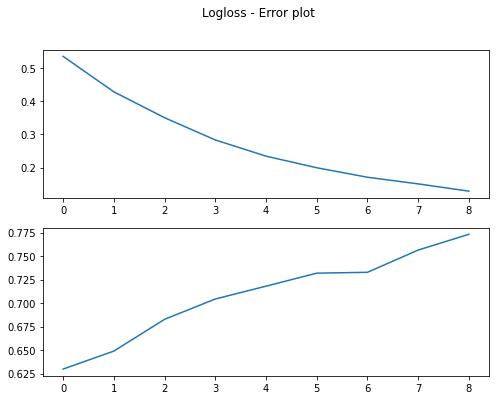

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(8, 6))
fig.suptitle('Logloss - Error plot')

axs[0].plot(class_xgb.evals_result()['validation_0']['logloss'])
axs[1].plot(class_xgb.evals_result()['validation_1']['logloss'])
plt.show()

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5000    0.1429    0.2222        14
           1     0.7000    0.9333    0.8000        30

    accuracy                         0.6818        44
   macro avg     0.6000    0.5381    0.5111        44
weighted avg     0.6364    0.6818    0.6162        44

Acurácia: 0.6818

AUC: 0.5381



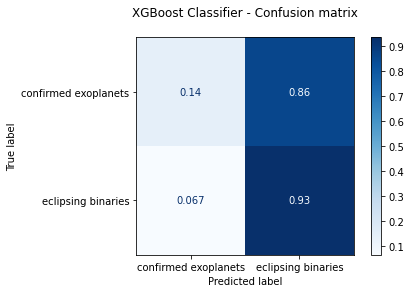

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

y_pred = class_xgb.predict(X_test)
 
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))
 
# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
 
# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# matriz de confusao

labels_formated = ['confirmed exoplanets', 'eclipsing binaries']

fig = plot_confusion_matrix(class_xgb, X_test, y_test,
                             display_labels=labels_formated,
                             cmap=plt.cm.Blues,
                             normalize='true'
                            )

fig.ax_.set_title('XGBoost Classifier - Confusion matrix\n')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

y_pred = class_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

scores = cross_val_score(class_xgb, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(class_xgb, X_train, y_train, cv=kfold )

print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Accuracy: 0.68
Mean cross-validation score: 0.72
K-fold CV average score: 0.71


### Final adjustments


In [ ]:
import seaborn as sns

importance_features = pd.DataFrame(class_xgb.feature_importances_, pd.DataFrame(X_train).columns)
importance_features = importance_features.sort_values(by=0, ascending=False)

(importance_features == 0).value_counts()

True     42
False    26
dtype: int64